# 0. Setup

In [1]:
! pip install transformers newspaper3k datasets urllib3==1.25.11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 23.2 MB/s 
     |████████████████████████████████| 211 kB 106.1 MB/s 
     |████████████████████████████████| 452 kB 89.1 MB/s 
     |████████████████████████████████| 127 kB 75.9 MB/s 
     |████████████████████████████████| 7.6 MB 76.4 MB/s 
     |████████████████████████████████| 182 kB 118.8 MB/s 
     |████████████████████████████████| 7.4 MB 48.7 MB/s 
     |████████████████████████████████| 93 kB 1.8 MB/s 
     |████████████████████████████████| 81 kB 13.1 MB/s 
     |████████████████████████████████| 132 kB 90.3 MB/s 
     |████████████████████████████████| 212 kB 77.0 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13552 sha256=154d66ee5428dc1348257e16bd237197563f24e8c54b74132e3590874e95483c
  Stored in directory: /root/.cache/pip/wheels/99/74/83/8fac1c8d9c648cfabebbbffe97a889f6624817f3aa0bbe

In [2]:
import urllib3
import os
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from newspaper import Article
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import datasets
from datasets import load_dataset
import transformers
from transformers import pipeline
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import spacy

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
import spacy

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
MAIN_FOLDER = '/content/drive/MyDrive/url_classification/'
HTML_FOLDER = MAIN_FOLDER + 'html_files_Nov-24-2022/'
os.chdir(MAIN_FOLDER)

# 0.1 Defining variables

In [7]:
URL = 'url'
TARGET = 'label'
TEXT = 'text'

# Constants that will disappear when transitioning to functions:
# Cell 1

html_folder = HTML_FOLDER
# Cell 2

# Name of the file that will origin 'df_text1'
csv_path1 = 'activities_unlabeled.csv'
usecols1 = ['File Name', 'Label']

nlp = spacy.load('en_core_web_sm')

In [8]:
# Name of the file that will origin 'df_text2'
csv_path = 'activities_labeled13.csv'
usecols = ['url', 'true_label']

In [9]:
# Cell 8

# Defining the classes that we are going to be working with and their encoded labels
labels_encoded = {'Article': 0, 'Blog': 1, 'Event': 2, 'Webinar': 3, 'PR': 4, 'MISC': 5}

labels_decoded = {y: x for x, y in labels_encoded.items()}
maximum_classes = len(labels_encoded)

In [10]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9A-Za-z #+_]')
STOPWORDS = set(stopwords.words('english'))

# 0.2 Functions

## Saving/loading variables

In [11]:
def save_variable(variable, variable_name):
  with open(f'./saved_variables/{variable_name}.pickle', 'wb') as f:
    pickle.dump(variable, f)

def read_variable(variable_name):
  with open(f'./saved_variables/{variable_name}.pickle', 'rb') as f:
    variable = pickle.load(f)
  return variable

def check_if_exists(variable_name):
  if variable_name in globals():
    print(f'Variable "{variable_name}" exists.')
  else:
    print(f'Variable "{variable_name}" does not exist.')

## Preprocessing

In [12]:
def get_most_common_tokens(df, column, amount=10):
  tokenized = [word_tokenize(string) for string in df[column]]
  flat_list = [item for sublist in tokenized for item in sublist]
  return Counter(flat_list).most_common(amount)

## Modeling

In [13]:
def fit_model(clf, X_train_transformed, y_train):
  clf.fit(X_train_transformed, y_train)
  return clf


def predict(clf, X_test_transformed):
  y_pred = clf.predict(X_test_transformed)
  return y_pred


def get_accuracy(y_test, y_pred):
  accuracy = sum(y_pred == y_test) / len(y_test)
  return accuracy


def print_important_features(clf, features=5):
  """ 
  Get the most important features of a classifier when using a linear kernel (e.g. Logistic Regression, not SVM)
  """
  coef_importances = np.argsort(clf.coef_, axis=1)
  
  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{labels_decoded[clf.classes_[i]]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')
      

def print_confusion_matrix(y_test, y_pred, with_report=False):

  accuracy = get_accuracy(y_test, y_pred)

  y_test = list(map(lambda x: labels_decoded[x], y_test))
  y_pred = list(map(lambda x: labels_decoded[x], y_pred))

  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.title(f'Confusion matrix - acc {accuracy:.3f}', size=15)
  plt.show()
  if with_report:
    print('\n' + classification_report(y_test, y_pred))


def get_best_clf(clfs, X_train, X_test, y_train, y_test):
    results = []
    best_clf = None
    best_clf_name = None
    best_accuracy = 0

    for clf_name, clf in clfs:
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test) # accuracy score
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_clf = clf
            best_clf_name = clf_name

        results.append({'clf': clf_name,
                        'accuracy': acc})
        
    print(pd.DataFrame(results).set_index('clf'))
    return best_clf, best_clf_name, best_accuracy


def print_train_val_len_start(train_index, val_index):
    print(f'TRAIN index len: {len(train_index)}, start: {train_index[:3]}, '
          f'\tVALIDATION index len: {len(val_index)}, start: {val_index[:3]}')

def print_val_scores(scores, extra_info=False):
    print(f'Cross validation scores: mean: {np.mean(scores):.3f}, all: {[round(score, 3) for score in scores]}')
    if extra_info:
        print('(std: {np.std(scores):.3f}, min: {min(scores):.3f}, max: {max(scores):.3f})')


def create_misclassified_df(X_test, y_test, y_pred):
  if type(y_pred) == np.ndarray and type(y_test) == pd.core.series.Series:
    y_pred = pd.Series(y_pred, index=y_test.index) # setting y_pred to same type and indexes as y_test
  
  mask = y_pred != y_test
  
  if type(y_pred) == np.ndarray and type(y_test) == np.ndarray:
    y_pred = pd.Series(y_pred)
    y_test = pd.Series(y_test)
    
  df = X_test.copy()[mask]
  df['y_true'] = y_test[mask].replace(labels_decoded)
  df['y_pred'] = y_pred[mask].replace(labels_decoded) 
  return df
  

# 0.3 (Optional) Load df_text1

In [14]:
check_if_exists('df_text1')
df_text1 = read_variable('df_text1')
check_if_exists('df_text1')
df_text1

Variable "df_text1" does not exist.
Variable "df_text1" exists.


,text,label
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event
1,When Is ADA Compliance Legally Required?. The ...,White Paper
2,Write For Us. Want to Write for Us? Digital L...,MISC
3,"Write for Us. Yes, you. We’re always looking f...",MISC
4,FAQs for some new features available in the Be...,Blog
...,...,...
456,"The Art of SEO, 2nd Edition. Four acknowledged...",Product Page
457,Submit A Guest Post – Guidelines (Write for Us...,MISC
458,Fully Managed Magento Hosting — JetRails. Full...,MISC
459,Mission-Critical Hosting For Magento Open Sour...,MISC


# 0.4 (Optional) Load "df_text2"

In [15]:
VARIABLE = 'df_text2'

check_if_exists(VARIABLE)
print(f'Reading variable "{VARIABLE}"...')
df_text2 = read_variable(VARIABLE)
check_if_exists(VARIABLE)

Variable "df_text2" does not exist.
Reading variable "df_text2"...
Variable "df_text2" exists.


In [16]:
df_text2

,url,text,label
0,http://www.nctech.org/events/event/2021/awards...,NC TECH Awards Gala. #nctechawards Awards Gal...,Event
1,http://cdd-biologics.com/,Computational Drug Development for Biologics 2...,Event
2,http://sfesummit.com/,12th Annual Sales Force Effectiveness & Digita...,Event
3,http://www.obviohealth.com/events/informa-1-2021,ObvioHealth. MAGI Clinical Research Conference...,Webinar
4,http://www.genesisconference.com/,Home : Genesis 2022.,Event
...,...,...,...
1014,http://www.entrepreneur.com/article/400416,Veeva Systems is a Top Stock for 2022. Veeva S...,Article
1015,http://www.koreabiomed.com/news/articleView.ht...,Medidata’s Acorn AI solution raises clinical t...,Article
1016,http://www.finsmes.com/2021/10/science-37-clos...,Science 37 Closes Business Combination with Li...,?
1017,http://seekingalpha.com/article/4450420-labora...,Laboratory Corp: 18%-20% Yearly Return With Sa...,-


# 0.5 (Optional) Load "df_text"

In [66]:
VARIABLE = 'df_text'

check_if_exists(VARIABLE)
print(f'Reading variable "{VARIABLE}"...')
df_text = read_variable(VARIABLE)
check_if_exists(VARIABLE)

Variable "df_text" exists.
Reading variable "df_text"...
Variable "df_text" exists.


# 0.6 (Optional) Create and save "df_text1" - general preprocessing of html

In [ ]:
# Important cell # 1
html_files = os.listdir(html_folder)

In [ ]:
# Important cell # 2

df1 = pd.read_csv(csv_path1, usecols=usecols)
df1.rename(columns={usecols1[0]: 'filename', usecols1[1]: TARGET}, inplace=True)
df1 = df1[~df1['filename'].isna()]
print(f'Original shape: {df1.shape}')
df1 = df1[df1[TARGET] != '-']
df1.reset_index(drop=True, inplace=True)
print(f'Final shape: {df1.shape}')

In [ ]:
# Important cell # 3
df1[TARGET].value_counts(normalize=False)

In [ ]:
# Important cell # 4
filenames = df1['filename'].values
htmls = list()

for i, filename in enumerate(filenames):
  try:
    with open(f'{HTML_FOLDER}{filename}') as f:
      html = f.read()
      htmls.append(html)
  except FileNotFoundError:
    print(f'File {i} not found: "{filename}"')

In [ ]:
# Important cell # 5
toi_articles = list()

for html in htmls:
  toi_article = Article(url = ' ', language = "en")
  toi_article.set_html(html)
  toi_article.parse()
  toi_article.nlp()
  toi_articles.append(toi_article)

In [ ]:
# Important cell # 6
y = df1[TARGET].tolist()

In [ ]:
# Important cell # 7
summaries = [(toi_article.title + '. ' + toi_article.text).replace('\n', ' ') for toi_article in toi_articles]

In [ ]:
assert len(y) == len(summaries)

In [ ]:
# Important cell # 7.5
df_text1 = pd.DataFrame({TEXT: summaries, TARGET: y})

In [ ]:
df_text1

In [ ]:
save_variable(df_text1, 'df_text1')

# 0.7 (Optional) Create and save "df_text2" - general preprocessing of urls

In [ ]:
csv_path

'activities_labeled13.csv'

In [ ]:
df_data = pd.read_csv(csv_path, usecols=usecols)
df_data.rename(columns={usecols[1]: TARGET}, inplace=True)
df_data = df_data[~df_data[TARGET].isna()]
df_data.reset_index(drop=True, inplace=True)

# All sections of blogs labeled as 'MISC/Blog?' become part of 'MISC'.
df_data.loc[df_data[TARGET] == 'MISC/Blog?', TARGET] = 'MISC'

In [ ]:
VARIABLE = 'labels_old'

try:
  labels_old = read_variable(VARIABLE)
  print(f'Variable {VARIABLE} already existed and contains {len(labels_old)} elements.')
except FileNotFoundError:
  labels_old = list()
  print(f'Variable {VARIABLE} was just created and contains {len(labels_old)} elements.')

Variable labels_old already existed and contains 953 elements.


In [ ]:
VARIABLE = 'indexes_old'

try:
  indexes_old = read_variable(VARIABLE)
  print(f'Variable {VARIABLE} already existed and contains {len(indexes_old)} elements.')
except FileNotFoundError:
  indexes_old = list()
  print(f'Variable {VARIABLE} was just created and contains {len(indexes_old)} elements.')

Variable indexes_old already existed and contains 953 elements.


In [ ]:
VARIABLE = 'texts_old'

try:
  texts_old = read_variable(VARIABLE)
  print(f'Variable {VARIABLE} already existed and contains {len(texts_old)} elements.')
except FileNotFoundError:
  texts_old = list()
  print(f'Variable {VARIABLE} was just created and contains {len(texts_old)} elements.')

Variable texts_old already existed and contains 953 elements.


In [ ]:
VARIABLE = 'urls_old'

try:
  urls_old = read_variable(VARIABLE)
  print(f'Variable {VARIABLE} already existed and contains {len(urls_old)} elements.')
except FileNotFoundError:
  urls_old = list()
  print(f'Variable {VARIABLE} was just created and contains {len(urls_old)} elements.')

Variable urls_old already existed and contains 1158 elements.


In [ ]:
# Read all variables in a single function that takes as parameter a list or a string (if type(x) == str: x = x.split())
# and create a for loop, storing each variable created in an array and then return all of them so:
# labels_old, indexes_old, texts_old, urls_old = func(x)

In [ ]:
urls = df_data['url']

# We use a mask to select the elements that are in 'urls' and not in 'urls_old' to create 'urls_new'.
mask = np.isin(urls, urls_old)
urls_new = urls[~mask]
print(f'There are {len(urls_new)} URLs to read.')

There are 88 URLs to read.


In [ ]:
# Important cell # 5
texts_new = list()
indexes_new = list()

idx_label_to_remove = list()
idx_label = 0

for i, url in enumerate(urls_new, len(urls_old)):
  try:
    toi_article = Article(url = url, language = "en")
    toi_article.download()
    toi_article.parse()
    toi_article.nlp()
    text = (toi_article.title + '. ' + toi_article.text).replace('\n', ' ')
    texts_new.append(text)
    indexes_new.append(i)
    print(f'{i}: url "{url}" read successfully.')
  except Exception:
    idx_label_to_remove.append(idx_label)
    print(f'{i}: ERROR: url "{url}" was not read successfully.')
  
  idx_label += 1

1158: url "http://seekingalpha.com/news/3739294-iqvia-partners-with-nrx-pharma-to-support-regulatory-pathway-for-covid-19-therapy" read successfully.
1159: url "http://www.healthcareitnews.com/news/emea/iqvia-partners-saudi-data-and-artificial-intelligence-authority-sdaia" read successfully.
1160: url "http://www.businesswire.com/news/home/20210805005130/en/Verily-Opens-New-RD-Center-in-Israel-Focused-on-the-Application-of-AI-in-Healthcare/?feedref=JjAwJuNHiystnCoBq_hl-RLXHJgazfQJNuOVHefdHP-D8R-QU5o2AvY8bhI9uvWSD8DYIYv4TIC1g1u0AKcacnnViVjtb72bOP4-4nHK5ieT3WxPE8m_kWI77F87CseT" read successfully.
1161: url "http://www.streetinsider.com/Press+Releases/StudyKIK%2C+A+Global+Clinical+Trial+Patient+Recruitment+%26amp%3B+Retention+Technology+Company%2C+Appoints+Kevin+Vass+as+Chief+Financial+Officer/18389562.html" read successfully.
1162: ERROR: url "http://www.bizjournals.com/sanfrancisco/news/2021/12/21/verily-google-andy-conrad-stephen-gillett.html?ana=RSS&s=article_search" was not read succ

In [ ]:
print(f'When reading the new URLs, {len(urls_new) - len(indexes_new)} of them threw an error and could not be read.')

When reading the new URLs, 22 of them threw an error and could not be read.


In [ ]:
labels_new = df_data.loc[urls_new.index, TARGET]

In [ ]:
assert (labels_new == df_data.loc[labels_new.index, TARGET]).all()

In [ ]:
labels_new.reset_index(drop=True, inplace=True)
labels_new = labels_new.drop(idx_label_to_remove).tolist()

In [ ]:
labels = labels_old + labels_new
indexes = indexes_old + indexes_new
texts = texts_old + texts_new

# We change the type and order of urls, deleting also the ones repeated in 'urls_old' and 'urls_new'
urls = urls_old + urls_new.tolist()

In [ ]:
assert len(texts) == len(pd.Series(urls).loc[indexes]) == len(indexes) == len(labels)

In [ ]:
df_text2 = pd.DataFrame({
    URL: pd.Series(urls).loc[indexes],
    TEXT: texts,
    TARGET: labels,
    }).reset_index(drop=True)

In [ ]:
save_variable(labels, 'labels_old')
save_variable(indexes, 'indexes_old')
save_variable(texts, 'texts_old')
save_variable(urls, 'urls_old')
save_variable(df_text2, 'df_text2')

# 0.8 (Optional) Create and save "df_text"

In [18]:
if df_text2[URL].duplicated().sum() == 0:
  print(f'There are no duplicate URLs or texts in df_text2.')
else:
  original_amount = df_text2.shape[0]
  df_text2 = df_text2[~df_text2[URL].duplicated()]
  print(f"{original_amount - df_text2.shape[0]} URLs were duplicates and hence deleted.")
  assert df_text2[URL].duplicated().sum() == 0

69 URLs were duplicates and hence deleted.


In [19]:
df_text = pd.concat([df_text1, df_text2]).reset_index(drop=True)

In [20]:
if df_text[TEXT].duplicated().sum() == 0:
  print(f'There are no duplicate URLs or texts in df_text.')
else:
  original_amount = df_text.shape[0]
  df_text = df_text[~df_text[TEXT].duplicated()]
  print(f"{original_amount - df_text.shape[0]} texts were duplicates and hence deleted.")
  assert df_text[TEXT].duplicated().sum() == 0

59 texts were duplicates and hence deleted.


In [21]:
# import seaborn as sns
# values = df_text['text'].str.split().str.len()
# sns.boxplot(x=values)
# plt.show()

In [49]:
df_text.shape

(1352, 3)

In [50]:
# Filtering out all texts with strings ' 404 ' and ' error ' than contain less than 100 words.
characters = df_text[TEXT].str.split().str.len()
condition = (df_text[TEXT].str.contains(' 404 ')) & (df_text[TEXT].str.contains(' error ')) & (characters < 100)
df_text = df_text[~condition]

In [51]:
df_text.shape

(1351, 3)

In [52]:
# To play with:

# THRESHOLD1 = 50
# THRESHOLD2 = 51

# characters = df_text[TEXT].str.split().str.len()
# df_text.loc[(characters >= THRESHOLD1) & (characters <= THRESHOLD2), TEXT].tolist()

In [ ]:
# By analizing the texts, errors started to show up in the ones that had below 51 words.

fraction_ignored = 0.165 # We will lose 16.5% of our data

values = df_text['text'].str.split().str.len()
minimum_words = values.quantile(fraction_ignored)
minimum_words

51.0

In [ ]:
values.describe()[['25%', '75%']]

25%     80.0
75%    593.0
Name: text, dtype: float64

In [53]:
df_text[TARGET].value_counts().head(7)

Webinar      208
Event        206
Blog         202
Home Page    196
PR           151
MISC         110
Article       87
Name: label, dtype: int64

In [54]:
df_text.shape

(1351, 3)

In [55]:
if maximum_classes:
  df_text = df_text[df_text[TARGET].isin(labels_encoded)]

df_text.reset_index(drop=True, inplace=True)

In [56]:
df_text.shape

(964, 3)

In [57]:
# Important cell # 8

# If the text a URL contains is below this threshold, it gets discarded
minimum_words = 51

if minimum_words:
  df_text = df_text[df_text[TEXT].str.split().str.len() >= minimum_words]

In [58]:
df_text.shape

(857, 3)

In [64]:
DISTILBERT_INPUT = 512
mask = df_text[TEXT].str.split().str.len() > DISTILBERT_INPUT
print(f'There are {mask.sum()} texts ({mask.sum() / df_text.shape[0]:.0%} of the total) that will be truncated by DistilBERT '
      f'for having more than {DISTILBERT_INPUT} words.')

There are 364 texts (42% of the total) that will be truncated by DistilBERT for having more than 512 words.


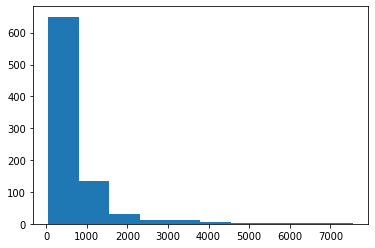

In [65]:
plt.hist(df_text[TEXT].str.split().str.len())
plt.show()

In [ ]:
# df_text.loc[df_text[TEXT].str.split().str.len() > DISTILBERT_EMBEDDINGS, TEXT].str.split().str.len()

In [ ]:
df_text.shape[0]

857

In [ ]:
df_text[TARGET].value_counts()

Blog       198
Event      174
Webinar    172
PR         150
Article     86
MISC        77
Name: label, dtype: int64

In [ ]:
# Important cell # 8
def clean_text(text):
    """
    @text: a string
    Returns a modified version of the initial string
    """
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text

print(f"Amount of words before cleaning text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
df_text['cleaned_text'] = df_text[TEXT].apply(clean_text)
print(f"Amount of words after cleaning text: {df_text['cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning text: {np.unique(np.concatenate(df_text['cleaned_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before cleaning text: 588737
Amount of unique words before cleaning text: 50526

Amount of words after cleaning text: 367289
Amount of unique words before cleaning text: 30237


In [ ]:
def lemmatize_text(text):
    lemmatized = ' '.join(token.lemma_ for token in nlp(text))
    return lemmatized

print(f"Amount of words before lemmatizing text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_text'] = df_text[TEXT].apply(lemmatize_text)
print(f"Amount of words after lemmatizing text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before lemmatizing text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before lemmatizing text: 588737
Amount of unique words before lemmatizing text: 50526

Amount of words after lemmatizing text: 707420
Amount of unique words before lemmatizing text: 23242


In [ ]:
print(f"Amount of words before cleaning lemmatized text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_text'].str.split().values, axis=0)).shape[0]}\n")
df_text['lemmatized_cleaned_text'] = df_text['lemmatized_text'].apply(clean_text)
print(f"Amount of words after cleaning lemmatized text: {df_text['lemmatized_cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")
print(f"Amount of unique words before cleaning lemmatized text: {np.unique(np.concatenate(df_text['lemmatized_cleaned_text'].str.split().values, axis=0)).shape[0]}")

Amount of words before cleaning lemmatized text: 707420
Amount of unique words before cleaning lemmatized text: 23242

Amount of words after cleaning lemmatized text: 351888
Amount of unique words before cleaning lemmatized text: 21922


In [ ]:
df_text.head(3) # df with different techniques for preprocessing of the text

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,Event,NaN,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...
1,Write For Us. Want to Write for Us? Digital L...,MISC,NaN,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...
2,"Write for Us. Yes, you. We’re always looking f...",MISC,NaN,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...


In [ ]:
df_text.loc[0, TEXT]

"2020 User Summit. 2020 User Summit  *UPDATE - March 12th, 2020*  With the ongoing coverage of the seriousness of the global outbreak of the COVID-19 virus and the potential effects, we want you to know that our priority is to keep our Summit attendees safe and informed.  While our AC User Summit is just more than a month away, we are sensitive to our clients' travel and safety. Out of an abundance of caution and concern, we have decided to cancel the 2020 User Summit in the best interest of all involved.  While we hope that we all can and will participate in normal activities as much as possible at this time, this is a unique situation that requires extra consideration for our clients and our employees.  Registration fees will be credited back to all clients who have registered for the Summit.  Thank you for your patience and understanding as we work through unprecedented times together."

In [ ]:
# df_text.loc[0, 'lemmatized_text']

In [ ]:
# df_text.loc[0, 'lemmatized_cleaned_text']

In [ ]:
def lemmatize_text2(text):
  lemmatized = ' '.join(token.text.lower() for token in nlp(text))
  return lemmatized

df_text['w2v_text'] = df_text[TEXT].apply(lemmatize_text2)

In [ ]:
# print(f"Amount of words before tokenizing text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
# print(f"Amount of unique words before tokenizing text: {np.unique(np.concatenate(df_text[TEXT].str.split().values, axis=0)).shape[0]}\n")
# tokenized = [word_tokenize(string) for string in df_text[TEXT]]
# df_text['tokenized'] = list(map(lambda x: ' '.join(x), tokenized))
# print(f"Amount of words after tokenizing text: {df_text['tokenized'].apply(lambda x: len(x.split(' '))).sum()}")
# print(f"Amount of unique words before tokenizing text: {np.unique(np.concatenate(df_text['tokenized'].str.split().values, axis=0)).shape[0]}")

In [ ]:
save_variable(df_text, 'df_text')

In [ ]:
# df_text = read_variable('df_text')

In [ ]:
df_text[TARGET].value_counts()

Blog       198
Event      174
Webinar    172
PR         150
Article     86
MISC        77
Name: label, dtype: int64

# 0.9 Further EDA and preprocessing on "df_text"

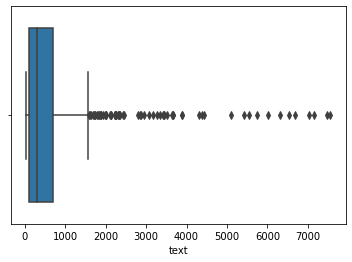

In [ ]:
import seaborn as sns
values = df_text['text'].str.split().str.len()
sns.boxplot(x=values)
plt.show()

values = df_text['text'].str.split().str.len()
minimum_words = values.quantile(0.15) # we ignore 15 % of the data, making sure the threshold ignores all outliers (< 0.25)
minimum_words

values.describe()[['25%', '75%']]

In [ ]:
values = df_text['text'].str.split().str.len()
minimum_words = values.quantile(0.15) # we ignore 15 % of the data, making sure the threshold ignores all outliers (< 0.25)
minimum_words

72.0

In [ ]:
values.describe()[['25%', '75%']]

25%    110.5
75%    697.5
Name: text, dtype: float64

In [ ]:
# df_text[TARGET].replace({1: 5}, inplace=True) # make Blog and Article a single category

In [ ]:
df_text[TARGET].value_counts()

5    176
0    128
7    124
6     85
2     79
4     55
3     44
Name: label, dtype: int64

In [ ]:
labels_encoded

{'Home Page': 0,
 'Blog': 1,
 'MISC': 2,
 'Product Page': 3,
 'Event': 4,
 'Article': 5,
 'Webinar': 6,
 'PR': 7}

# 1. BoW approach

## Preprocessing

In [250]:
labels_encoded

{'Article': 0, 'Blog': 1, 'Event': 2, 'Webinar': 3, 'PR': 4, 'MISC': 5}

In [251]:
df_text[TARGET] = df_text[TARGET].replace(labels_encoded)

In [252]:
# # Working only with df_text2
# df_text = df_text[(df_text['url'] != 'Not provided') & (df_text[TARGET].isin([7, 6, 4, 1, 5]))]

In [253]:
df_text[TARGET].value_counts()

1    198
2    174
3    172
4    150
0     86
5     77
Name: label, dtype: int64

In [254]:
df_text.shape[0]

857

In [255]:
# df_positive = df_text[df_text[TARGET] != 5]
# df_negative = df_text[df_text[TARGET] == 5]

# Cell 9
test_size = 0.2
random_state = 1

# Important cell # 9
column_used = 'lemmatized_cleaned_text'

# X = df_positive[[column_used]]
# y = df_positive[TARGET]
X = df_text[[column_used]]
y = df_text[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state
                                                    )

# X_misc = df_negative[[column_used]]
# y_misc = df_negative[TARGET]
# X_test = pd.concat([X_test, X_misc])
# y_test = pd.concat([y_test, y_misc])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((685, 1), (172, 1), (685,), (172,))

In [256]:
# Important cell # 10
majority_class = y_train.value_counts().index[0]
baseline_accuracy = sum(y_test == majority_class) / len(y_test)
print(f'Baseline accuracy: {baseline_accuracy:.4f}')

Baseline accuracy: 0.2326


In [257]:
get_most_common_tokens(df=df_text, column='lemmatized_cleaned_text', amount=10)

[('use', 2189),
 ('patient', 1949),
 ('clinical', 1801),
 ('trial', 1733),
 ('datum', 1646),
 ('company', 1532),
 ('I', 1511),
 ('make', 1432),
 ('content', 1423),
 ('need', 1275)]

In [258]:
# Important cell # 11
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_tr = vectorizer.fit_transform(X_train[column_used])
X_test_tr = vectorizer.transform(X_test[column_used])

In [259]:
X_train_tr.toarray().shape, X_test_tr.toarray().shape

((685, 418869), (172, 418869))

In [260]:
# import string

# # STOPWORDS = stop_words.ENGLISH_STOP_WORDS

# #Function for basic cleaning/preprocessing texts
# def clean(doc):
#     # Removal of punctuation marks (.,/\][{} etc) and numbers
#     doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
#     # Removal of stopwords
#     doc = " ".join([token for token in doc.split() if token not in STOPWORDS])
#     return doc.lower()

# string.punctuation

## Modeling

In [261]:
clfs = [
    ('LogisticRegression', LogisticRegression(max_iter=3000,
                                              class_weight='balanced')), 
    ('RandomForest', RandomForestClassifier(max_depth=18,
                                            n_estimators=75,
                                            random_state=0)), 
    ('KNN 5', KNeighborsClassifier(n_neighbors=5)),
    ('SVM C1', SVC(C=1, 
                   class_weight='balanced')),
    ('MultinomialNB', MultinomialNB())
]

In [262]:
for clf in clfs:
  print(f'\nStratifiedKFold - classifier: {clf[0]}:\n')
  skf = StratifiedKFold(n_splits=5)
  for train_index, val_index in skf.split(X_train_tr, y_train):
      print_train_val_len_start(train_index, val_index)
      print(f'\tMean y: TRAIN: {y_train.iloc[train_index].mean():.3f},\tVALIDATION: {y_train.iloc[val_index].mean():.3f}')

  scores = cross_val_score(clf[1], 
                          X_train_tr,
                          y_train,
                          cv=5)
  
  print_val_scores(scores)


StratifiedKFold - classifier: LogisticRegression:

TRAIN index len: 548, start: [125 127 131], 	VALIDATION index len: 137, start: [0 1 2]
	Mean y: TRAIN: 2.389,	VALIDATION: 2.394
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [125 127 131]
	Mean y: TRAIN: 2.385,	VALIDATION: 2.409
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [239 240 242]
	Mean y: TRAIN: 2.394,	VALIDATION: 2.372
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [375 376 378]
	Mean y: TRAIN: 2.391,	VALIDATION: 2.387
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index len: 137, start: [482 484 497]
	Mean y: TRAIN: 2.391,	VALIDATION: 2.387
Cross validation scores: mean: 0.745, all: [0.708, 0.715, 0.737, 0.781, 0.781]

StratifiedKFold - classifier: RandomForest:

TRAIN index len: 548, start: [125 127 131], 	VALIDATION index len: 137, start: [0 1 2]
	Mean y: TRAIN: 2.389,	VALIDATION: 2.394
TRAIN index len: 548, start: [0 1 2], 	VALIDATION index

In [263]:
y_train.value_counts(normalize=True)

1    0.230657
2    0.202920
3    0.200000
4    0.175182
0    0.100730
5    0.090511
Name: label, dtype: float64

In [264]:
y_test.value_counts(normalize=True)

1    0.232558
2    0.203488
3    0.203488
4    0.174419
0    0.098837
5    0.087209
Name: label, dtype: float64

Checking results on the test set:

In [265]:
# clf, clf_name, val_acc = get_best_clf(clfs, X_train, X_test, y_train, y_test)
# print(f'Best classifier: {clf_name}, validation accuracy: {val_acc:.3f}, '
#       f'test accuracy: {clf.score(X_test, y_test):.3f}')

clf, clf_name, test_acc = get_best_clf(clfs, X_train_tr, X_test_tr, y_train, y_test)
print(f'Best classifier: {clf_name}, test accuracy: {test_acc:.3f}')

                    accuracy
clf                         
LogisticRegression  0.767442
RandomForest        0.674419
KNN 5               0.622093
SVM C1              0.703488
MultinomialNB       0.558140
Best classifier: LogisticRegression, test accuracy: 0.767


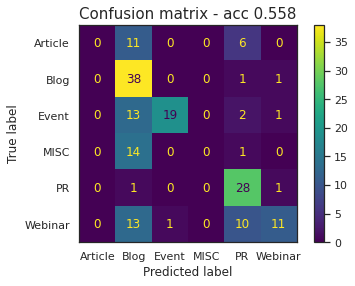


              precision    recall  f1-score   support

     Article       0.00      0.00      0.00        17
        Blog       0.42      0.95      0.58        40
       Event       0.95      0.54      0.69        35
        MISC       0.00      0.00      0.00        15
          PR       0.58      0.93      0.72        30
     Webinar       0.79      0.31      0.45        35

    accuracy                           0.56       172
   macro avg       0.46      0.46      0.41       172
weighted avg       0.55      0.56      0.49       172



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [266]:
clf = fit_model(MultinomialNB(),
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

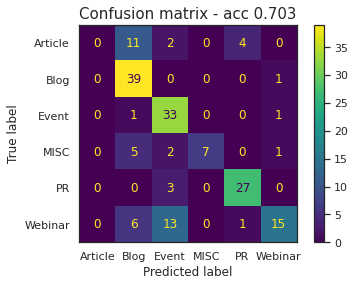


              precision    recall  f1-score   support

     Article       0.00      0.00      0.00        17
        Blog       0.63      0.97      0.76        40
       Event       0.62      0.94      0.75        35
        MISC       1.00      0.47      0.64        15
          PR       0.84      0.90      0.87        30
     Webinar       0.83      0.43      0.57        35

    accuracy                           0.70       172
   macro avg       0.65      0.62      0.60       172
weighted avg       0.68      0.70      0.65       172



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [267]:
clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

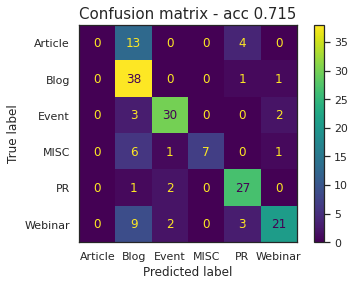


              precision    recall  f1-score   support

     Article       0.00      0.00      0.00        17
        Blog       0.54      0.95      0.69        40
       Event       0.86      0.86      0.86        35
        MISC       1.00      0.47      0.64        15
          PR       0.77      0.90      0.83        30
     Webinar       0.84      0.60      0.70        35

    accuracy                           0.72       172
   macro avg       0.67      0.63      0.62       172
weighted avg       0.69      0.72      0.68       172



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [268]:
clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced'
                                   ), 
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

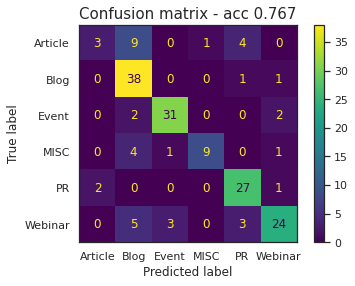


              precision    recall  f1-score   support

     Article       0.60      0.18      0.27        17
        Blog       0.66      0.95      0.78        40
       Event       0.89      0.89      0.89        35
        MISC       0.90      0.60      0.72        15
          PR       0.77      0.90      0.83        30
     Webinar       0.83      0.69      0.75        35

    accuracy                           0.77       172
   macro avg       0.77      0.70      0.71       172
weighted avg       0.77      0.77      0.75       172



In [269]:
clf = fit_model(LogisticRegression(
    max_iter=3000, 
    class_weight='balanced'
    ), 
    X_train_tr, 
    y_train,
    )

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

In [270]:
X_train_tr.toarray().shape

(685, 418869)

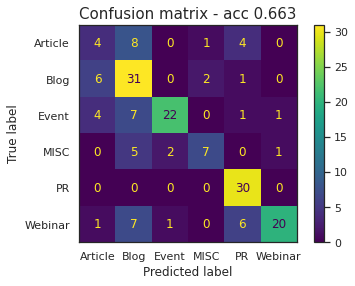


              precision    recall  f1-score   support

     Article       0.27      0.24      0.25        17
        Blog       0.53      0.78      0.63        40
       Event       0.88      0.63      0.73        35
        MISC       0.70      0.47      0.56        15
          PR       0.71      1.00      0.83        30
     Webinar       0.91      0.57      0.70        35

    accuracy                           0.66       172
   macro avg       0.67      0.61      0.62       172
weighted avg       0.70      0.66      0.66       172



In [271]:
clf = fit_model(LogisticRegression(
    max_iter=3000, 
    class_weight='balanced',
    solver='liblinear', # default: 'lbfgs' 
    penalty='l1', # default: 'l2'
    ), 
    X_train_tr, 
    y_train,
    )

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

In [272]:
print_important_features(clf, features=5)

Class "Article" - 5 most important features: ['000' 'point show nice' 'point show' 'point shot succeed' 'point shot']
Class "Blog" - 5 most important features: ['clinical' 'iqvia' '000' 'point show' 'point shot succeed']
Class "Event" - 5 most important features: ['patient' 'iqvia' '000' 'point show' 'point shot succeed']
Class "Webinar" - 5 most important features: ['000' 'point show' 'point shot succeed' 'point shot' 'point shop online']
Class "PR" - 5 most important features: ['000' 'point show nice' 'point show' 'point shot succeed' 'point shot']
Class "MISC" - 5 most important features: ['patient' 'clinical' '000' 'point show nice' 'point show']


In [273]:
misclassified_df = create_misclassified_df(X_test, y_test, y_pred)
assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
misclassified_df

,lemmatized_cleaned_text,y_true,y_pred
292,Co produce Demy Colton EBD Group externalizati...,Event,Blog
326,Veeva MedTech Regulatory Community Meeting Thu...,Webinar,Blog
306,EUROTOX Congress 2021 dear Friends Colleagues ...,Event,Blog
138,url csscolon cascade style sheet url css funct...,Article,Blog
136,Cache web api Cache interface provide persiste...,Article,Blog
848,health system really work like system I start ...,Blog,PR
924,ObvioHealth launch clinical trial Anatara garp...,Article,PR
105,Repurposing Content develop new material conte...,Article,Blog
207,millennial really want work thing rest Us Do f...,Article,MISC
377,Gognitive Cyber artificial intelligence play i...,Event,Blog


In [274]:
INDEX = 0
true_index = misclassified_df.index[INDEX]
misclassified_df.loc[true_index, 'lemmatized_cleaned_text']

'Co produce Demy Colton EBD Group externalization team HOYA identify several partner investment participation Biotech Showcase Digital Medicine Medtech Showcase past several year diversity technology stage development offer good scouting future investment expand internal product pipeline core strategic well adjacent area EYE GI'

# 2. DistilBERT approach (Ashwin N)

### Preprocessing

In [ ]:
df_text[TARGET] = df_text[TARGET].replace(labels_encoded)

In [73]:
# df_positive = df_text[df_text[TARGET] != 5]
# df_negative = df_text[df_text[TARGET] == 5]

# Cell 9
test_size = 0.2
val_size = 0.1
random_state = 1

# Important cell # 9
column_used = 'text'

# X = df_positive[[column_used]]
# y = df_positive[TARGET]
X = df_text[[column_used]]
y = df_text[TARGET]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                    test_size=1/((1-test_size)/val_size),
                                                    stratify=y_train_val, 
                                                    random_state=random_state)

# X_misc = df_negative[[column_used]]
# y_misc = df_negative[TARGET]
# X_test = pd.concat([X_test, X_misc])
# y_test = pd.concat([y_test, y_misc])

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((599, 1), (86, 1), (172, 1), (599,), (86,), (172,))

In [74]:
y_train.value_counts()

1    138
2    122
3    120
4    105
0     60
5     54
Name: label, dtype: int64

In [75]:
y_val.value_counts()

1    20
2    17
3    17
4    15
0     9
5     8
Name: label, dtype: int64

In [76]:
y_test.value_counts()

1    40
2    35
3    35
4    30
0    17
5    15
Name: label, dtype: int64

In [77]:
X_train

,text
338,4th Virtual Clinical Trials. Switching to virt...
50,Guest Post Requests – for all – Birds on the B...
838,The many options of the Cloud Continuum. Summe...
907,Partnering up: How biopharma commercial and R&...
822,RNSA 2021: BrightInsight’s post-conference per...
...,...
173,Home Wiring the Rez: Innovative Strategies for...
602,Webinar: Rare Disease Clinical Trials: Being I...
797,Putting the Pieces Together for Quality Health...
244,Enhancing the patient experience in clinical t...


In [78]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

dataset = DatasetDict(
    {
    'train': Dataset.from_dict(
        {'text': X_train[column_used],
         'label': y_train,
         }
         ),
    'validation': Dataset.from_dict(
        {'text': X_val[column_used],
         'label': y_val,
         }
         ),
    'test': Dataset.from_dict(
        {'text': X_test[column_used],
         'label': y_test,
         }
         ),
    }
    )

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 599
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 86
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 172
    })
})

In [79]:
train_ds = dataset['train']

In [80]:
print(train_ds[:5])

{'text': ['4th Virtual Clinical Trials. Switching to virtual trials requires more than just running standard methods in front of a webcam. Your entire clinical approach must be reconceptualized in order to get the most benefit from a virtual approach. Lack of industry-wide standards is the biggest barrier to collecting and leveraging patient data; each pharma company or vendor may have their own set of systems or safety tools, and integrating these can be a huge obstacle for your pipeline.', 'Guest Post Requests – for all – Birds on the Blog. Your guest post needs to be business focused. It can be about a business challenge that you’ve overcome. It can be a tutorial or how-to post. It can be about a cause you wish to raise awareness for.  But you need to know a few things first… we don’t link to:  Porn  Adult sites without prior approval  Men-hating sites  Women hating sites  Racist or homophobic content  Gambling  Payday loans  Companies of dubious business reputation.  The article yo

In [81]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
# model_ckpt = 'bert-base-uncased' # Node: 'tf_bert_for_sequence_classification/bert/encoder/layer_._8/intermediate/Gelu/mul_1' failed to allocate memory
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [82]:
text = "Tokenizing text is a core task of NLP 2021. See you on 31/12/2022."
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 25682, 1012, 2156, 2017, 2006, 2861, 1013, 2260, 1013, 16798, 2475, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [83]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '2021', '.', 'see', 'you', 'on', '31', '/', '12', '/', '202', '##2', '.', '[SEP]']


In [84]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp 2021. see you on 31 / 12 / 2022. [SEP]


In [85]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [86]:
print(tokenize(dataset["train"][:2])) 

{'input_ids': [[101, 4343, 7484, 6612, 7012, 1012, 11991, 2000, 7484, 7012, 5942, 2062, 2084, 2074, 2770, 3115, 4725, 1999, 2392, 1997, 1037, 4773, 28727, 1012, 2115, 2972, 6612, 3921, 2442, 2022, 28667, 2239, 3401, 13876, 8787, 3550, 1999, 2344, 2000, 2131, 1996, 2087, 5770, 2013, 1037, 7484, 3921, 1012, 3768, 1997, 3068, 1011, 2898, 4781, 2003, 1996, 5221, 8803, 2000, 9334, 1998, 15929, 16594, 5776, 2951, 1025, 2169, 6887, 27292, 2050, 2194, 2030, 21431, 2089, 2031, 2037, 2219, 2275, 1997, 3001, 2030, 3808, 5906, 1010, 1998, 22380, 2122, 2064, 2022, 1037, 4121, 18355, 2005, 2115, 13117, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [87]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [88]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 599
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 86
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 172
    })
})

In [89]:
from transformers import TFAutoModel 
tf_model = TFAutoModel.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [90]:
text = "this is a test"
inputs = tokenizer(text, return_tensors='tf')
inputs

{'input_ids': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[ 101, 2023, 2003, 1037, 3231,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [91]:
outputs = tf_model(inputs)
outputs

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(1, 6, 768), dtype=float32, numpy=
array([[[-0.15651304, -0.18619652,  0.0527766 , ..., -0.11881151,
          0.06620612,  0.54701567],
        [-0.35751358, -0.6483556 , -0.06178969, ..., -0.30401963,
          0.35076863,  0.5220685 ],
        [-0.27718437, -0.4459444 ,  0.18184267, ..., -0.09477945,
         -0.0075747 ,  0.9958283 ],
        [-0.2840854 , -0.39167666,  0.37525564, ..., -0.21505743,
         -0.1172516 ,  1.0526477 ],
        [ 0.26608238, -0.50936407, -0.31801325, ..., -0.42029822,
          0.01444231, -0.21489474],
        [ 0.9440614 ,  0.01117298, -0.47139406, ...,  0.14394695,
         -0.72878385, -0.16194941]]], dtype=float32)>, hidden_states=None, attentions=None)

In [92]:
outputs.last_hidden_state.shape

TensorShape([1, 6, 768])

In [93]:
dataset_encoded.reset_format()

def extract_hidden_states(batch):
    # First convert text to tokens
    inputs = tokenizer(
        batch["text"], 
        padding=True, 
        truncation=True, 
        return_tensors='tf',
        )
    # Extract last hidden states
    outputs = tf_model(inputs)
     # Return vector for [CLS] token
    return {"hidden_state": outputs.last_hidden_state[:,0].numpy()}

In [94]:
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True, batch_size=16)
dataset_hidden

  0%|          | 0/38 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 599
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 86
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 172
    })
})

In [95]:
import numpy as np
X_train_ = np.array(dataset_hidden["train"]["hidden_state"])
X_valid_ = np.array(dataset_hidden["validation"]["hidden_state"])
y_train_ = np.array(dataset_hidden["train"]["label"])
y_valid_ = np.array(dataset_hidden["validation"]["label"])
X_train_.shape, X_valid_.shape, y_train_.shape, y_valid_.shape

((599, 768), (86, 768), (599,), (86,))

In [96]:
X_test_ = np.array(dataset_hidden["test"]["hidden_state"])
y_test_ = np.array(dataset_hidden["test"]["label"])
X_test_.shape, y_test.shape

((172, 768), (172,))

In [97]:
X_train_

array([[-0.10770728, -0.03365175,  0.08075761, ..., -0.4514001 ,
         0.11417604,  0.34555456],
       [ 0.15932746,  0.03513003, -0.01458935, ..., -0.06776141,
         0.28784022,  0.34472507],
       [-0.00853348, -0.00116383,  0.1005832 , ..., -0.08488505,
         0.41801274,  0.35462543],
       ...,
       [-0.26353878, -0.13307309, -0.01608189, ..., -0.13173831,
         0.2407387 ,  0.23747839],
       [-0.2692731 , -0.07734857,  0.08480839, ..., -0.37410772,
         0.23908147,  0.17481402],
       [-0.20388588, -0.21797237,  0.15804723, ..., -0.24696341,
         0.35262108,  0.31379992]])

In [98]:
X_train_valid_ = np.concatenate([X_train_, X_valid_])
X_train_.shape, X_valid_.shape, X_train_valid_.shape

((599, 768), (86, 768), (685, 768))

In [99]:
y_train_valid_ = np.concatenate([y_train_, y_valid_])
y_train_.shape, y_valid_.shape, y_train_valid_.shape

((599,), (86,), (685,))

In [100]:
# X_valid_test_ = np.concatenate([X_valid_, X_test_])
# X_valid_.shape, X_test_.shape, X_valid_test_.shape

In [101]:
# y_valid_test_ = np.concatenate([y_valid_, y_test_])
# y_valid_.shape, y_test_.shape, y_valid_test_.shape

### a) Modeling - ML approach:

In [102]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_valid_, y_train_valid_)
lr_clf.score(X_test_, y_test_)

0.7848837209302325

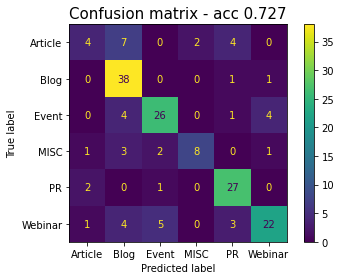


              precision    recall  f1-score   support

     Article       0.50      0.24      0.32        17
        Blog       0.68      0.95      0.79        40
       Event       0.76      0.74      0.75        35
        MISC       0.80      0.53      0.64        15
          PR       0.75      0.90      0.82        30
     Webinar       0.79      0.63      0.70        35

    accuracy                           0.73       172
   macro avg       0.71      0.67      0.67       172
weighted avg       0.72      0.73      0.71       172



In [103]:
rf_clf = fit_model(RandomForestClassifier(max_depth=10,
                                            n_estimators=50,
                                            random_state=0,
                                          ),
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(rf_clf, X_test_)
y_probs = rf_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

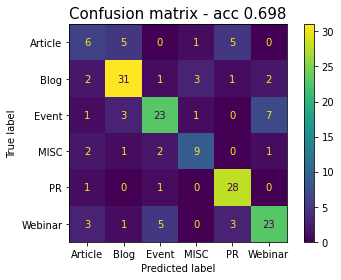


              precision    recall  f1-score   support

     Article       0.40      0.35      0.38        17
        Blog       0.76      0.78      0.77        40
       Event       0.72      0.66      0.69        35
        MISC       0.64      0.60      0.62        15
          PR       0.76      0.93      0.84        30
     Webinar       0.70      0.66      0.68        35

    accuracy                           0.70       172
   macro avg       0.66      0.66      0.66       172
weighted avg       0.69      0.70      0.69       172



In [104]:
svc_clf = fit_model(SVC(C=1, 
                    class_weight='balanced'
                    ),
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(svc_clf, X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

In [105]:
X_train_.shape

(599, 768)

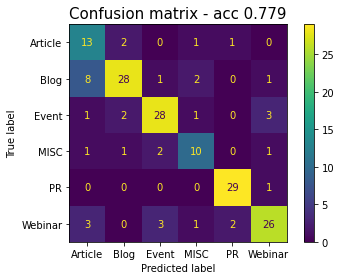


              precision    recall  f1-score   support

     Article       0.50      0.76      0.60        17
        Blog       0.85      0.70      0.77        40
       Event       0.82      0.80      0.81        35
        MISC       0.67      0.67      0.67        15
          PR       0.91      0.97      0.94        30
     Webinar       0.81      0.74      0.78        35

    accuracy                           0.78       172
   macro avg       0.76      0.77      0.76       172
weighted avg       0.80      0.78      0.78       172



In [106]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced', 
                                   ), 
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(lr_clf, X_test_)
y_probs = lr_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

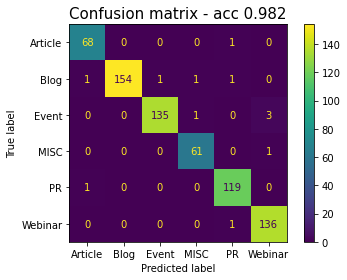


              precision    recall  f1-score   support

     Article       0.97      0.99      0.98        69
        Blog       1.00      0.97      0.99       158
       Event       0.99      0.97      0.98       139
        MISC       0.97      0.98      0.98        62
          PR       0.98      0.99      0.98       120
     Webinar       0.97      0.99      0.98       137

    accuracy                           0.98       685
   macro avg       0.98      0.98      0.98       685
weighted avg       0.98      0.98      0.98       685



In [107]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_valid_)
print_confusion_matrix(y_train_valid_, y_pred_train, with_report=True)

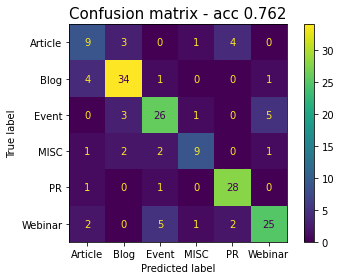


              precision    recall  f1-score   support

     Article       0.53      0.53      0.53        17
        Blog       0.81      0.85      0.83        40
       Event       0.74      0.74      0.74        35
        MISC       0.75      0.60      0.67        15
          PR       0.82      0.93      0.87        30
     Webinar       0.78      0.71      0.75        35

    accuracy                           0.76       172
   macro avg       0.74      0.73      0.73       172
weighted avg       0.76      0.76      0.76       172



In [108]:
lr_clf = fit_model(LogisticRegression(
    max_iter=3000, 
    class_weight='balanced',
    solver='liblinear', # default: 'lbfgs' 
    penalty='l1', # default: 'l2'
    ), 
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(lr_clf, X_test_)
y_probs = lr_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

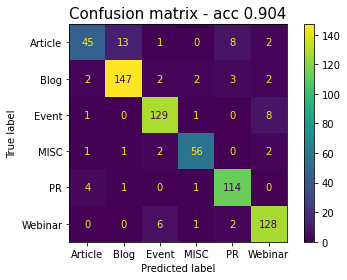


              precision    recall  f1-score   support

     Article       0.85      0.65      0.74        69
        Blog       0.91      0.93      0.92       158
       Event       0.92      0.93      0.92       139
        MISC       0.92      0.90      0.91        62
          PR       0.90      0.95      0.92       120
     Webinar       0.90      0.93      0.92       137

    accuracy                           0.90       685
   macro avg       0.90      0.88      0.89       685
weighted avg       0.90      0.90      0.90       685



In [109]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_valid_)
print_confusion_matrix(y_train_valid_, y_pred_train, with_report=True)

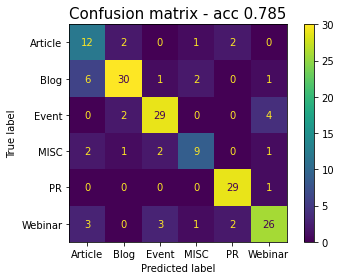


              precision    recall  f1-score   support

     Article       0.52      0.71      0.60        17
        Blog       0.86      0.75      0.80        40
       Event       0.83      0.83      0.83        35
        MISC       0.69      0.60      0.64        15
          PR       0.88      0.97      0.92        30
     Webinar       0.79      0.74      0.76        35

    accuracy                           0.78       172
   macro avg       0.76      0.77      0.76       172
weighted avg       0.79      0.78      0.79       172



In [110]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                  #  class_weight='balanced', 
                                   ), 
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(lr_clf, X_test_)
y_probs = lr_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

In [111]:
# lr_clf = fit_model(LogisticRegression(
#     max_iter=3000, 
#     class_weight='balanced',
#     solver='saga', # default: 'lbfgs' 
#     penalty='elasticnet', # default: 'l2',
#     l1_ratio=0.9, # only relevant when penalty='elasticnet'
#     ), 
#                 X_train_, 
#                 y_train_)

# y_pred = predict(lr_clf, X_valid_test_)
# y_probs = lr_clf.predict_proba(X_valid_test_)

# print_confusion_matrix(y_valid_test_, y_pred, with_report=True)

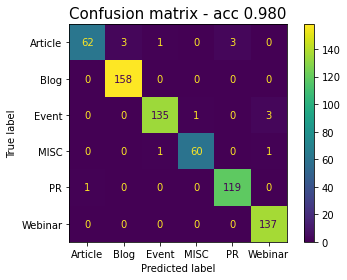


              precision    recall  f1-score   support

     Article       0.98      0.90      0.94        69
        Blog       0.98      1.00      0.99       158
       Event       0.99      0.97      0.98       139
        MISC       0.98      0.97      0.98        62
          PR       0.98      0.99      0.98       120
     Webinar       0.97      1.00      0.99       137

    accuracy                           0.98       685
   macro avg       0.98      0.97      0.98       685
weighted avg       0.98      0.98      0.98       685



In [112]:
# Check if it's overfitting
y_pred_train = predict(lr_clf, X_train_valid_)
print_confusion_matrix(y_train_valid_, y_pred_train, with_report=True)

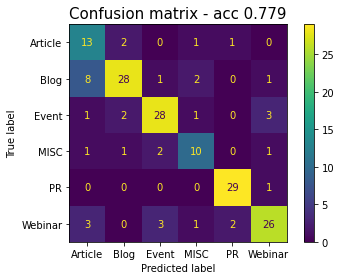


              precision    recall  f1-score   support

     Article       0.50      0.76      0.60        17
        Blog       0.85      0.70      0.77        40
       Event       0.82      0.80      0.81        35
        MISC       0.67      0.67      0.67        15
          PR       0.91      0.97      0.94        30
     Webinar       0.81      0.74      0.78        35

    accuracy                           0.78       172
   macro avg       0.76      0.77      0.76       172
weighted avg       0.80      0.78      0.78       172



In [113]:
lr_clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced', 
                                   ), 
                X_train_valid_, 
                y_train_valid_)

y_pred = predict(lr_clf, X_test_)
y_probs = lr_clf.predict_proba(X_test_)

print_confusion_matrix(y_test_, y_pred, with_report=True)

In [114]:
pickle.dump(lr_clf, open('/content/drive/MyDrive/url_classification/Models/distilbert_lr_clf', 'wb'))

In [115]:
# lr_clf = pickle.load(open('/content/drive/MyDrive/url_classification/Models/distilbert_lr_clf', 'rb'))

In [116]:
df_text

,text,label,url,cleaned_text,lemmatized_text,lemmatized_cleaned_text,w2v_text
0,2020 User Summit. 2020 User Summit *UPDATE - ...,2,NaN,2020 User Summit 2020 User Summit UPDATE March...,2020 User Summit . 2020 User Summit * update...,2020 User Summit 2020 User Summit update March...,2020 user summit . 2020 user summit * update...
1,Write For Us. Want to Write for Us? Digital L...,5,NaN,Write For Us Want Write Us Digital Lamp one fa...,write for we . want to write for we ? Digita...,write want write Digital Lamp one fast grow te...,write for us . want to write for us ? digita...
2,"Write for Us. Yes, you. We’re always looking f...",5,NaN,Write Us Yes Were always looking new authors I...,"write for we . yes , you . we ’re always look ...",write yes always look new author get idea chal...,"write for us . yes , you . we ’re always looki..."
3,FAQs for some new features available in the Be...,1,NaN,FAQs new features available Beta Wayback Machi...,FAQs for some new feature available in the Bet...,FAQs new feature available Beta Wayback Machin...,faqs for some new features available in the be...
4,The Best Nootropic Stack to Replace Adderall &...,0,NaN,The Best Nootropic Stack Replace Adderall Rita...,the Best Nootropic Stack to replace Adderall &...,Best Nootropic Stack replace Adderall Ritalin ...,the best nootropic stack to replace adderall &...
...,...,...,...,...,...,...,...
959,Veeva Systems Korea aims to become cloud SW le...,0,http://www.koreabiomed.com/news/articleView.ht...,Veeva Systems Korea aims become cloud SW leade...,Veeva Systems Korea aim to become cloud SW lea...,Veeva Systems Korea aim become cloud SW leader...,veeva systems korea aims to become cloud sw le...
960,Digital transformation of clinical research ac...,0,http://www.outsourcing-pharma.com/Article/2021...,Digital transformation clinical research accel...,digital transformation of clinical research ac...,digital transformation clinical research accel...,digital transformation of clinical research ac...
961,Veeva Systems is a Top Stock for 2022. Veeva S...,0,http://www.entrepreneur.com/article/400416,Veeva Systems Top Stock 2022 Veeva Systems VEE...,Veeva Systems be a Top Stock for 2022 . Veeva ...,Veeva Systems Top Stock 2022 Veeva Systems VEE...,veeva systems is a top stock for 2022 . veeva ...
962,Medidata’s Acorn AI solution raises clinical t...,0,http://www.koreabiomed.com/news/articleView.ht...,Medidatas Acorn AI solution raises clinical tr...,Medidata ’s Acorn AI solution raise clinical t...,Medidata Acorn AI solution raise clinical tria...,medidata ’s acorn ai solution raises clinical ...


In [117]:
labels_encoded

{'Article': 0, 'Blog': 1, 'Event': 2, 'Webinar': 3, 'PR': 4, 'MISC': 5}

In [118]:
mask = y_pred != y_test_

In [119]:
X_test = pd.DataFrame(X_test, columns=['text']) # transform into DataFrame

misclassified_df = create_misclassified_df(X_test=X_test, y_test=y_test, y_pred=y_pred)
assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
misclassified_df.head()

,text,y_true,y_pred
429,"GM Only Webinar. Dear General Managers, At AHL...",Webinar,MISC
326,Veeva MedTech Regulatory Community Meeting. Th...,Webinar,Event
68,8 Modern Tips for Marketing to Millennials. Yo...,Blog,Article
100,"The Pros, Cons, and Costs of the Top 10 Conten...",Blog,Article
207,What Do Millennials Really Want at Work? The S...,Article,MISC


In [120]:
# X_valid_test = np.concatenate([X_val, X_test]) # concatenate
# X_valid_test = pd.DataFrame(X_valid_test, columns=['text']) # transform into DataFrame

# misclassified_df = create_misclassified_df(X_test=X_valid_test, y_test=y_valid_test_, y_pred=y_pred)
# assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
# misclassified_df

In [121]:
misclassified_df.shape

(38, 3)

In [122]:
df_merged = pd.merge(misclassified_df, df_text[['url', 'text']], on='text')
df_merged.index = misclassified_df.index
df_merged

,text,y_true,y_pred,url
429,"GM Only Webinar. Dear General Managers, At AHL...",Webinar,MISC,http://contentsharing.net/actions/email_web_ve...
326,Veeva MedTech Regulatory Community Meeting. Th...,Webinar,Event,http://go.veeva.com/l/28972/2021-05-01/95h4fv
68,8 Modern Tips for Marketing to Millennials. Yo...,Blog,Article,NaN
100,"The Pros, Cons, and Costs of the Top 10 Conten...",Blog,Article,NaN
207,What Do Millennials Really Want at Work? The S...,Article,MISC,NaN
377,Gognitive Cyber. Artificial intelligence is pl...,Event,Webinar,http://www.menaisc.com/
84,"How to Use Hashtags: How Many, Best Ones, and ...",Blog,Article,NaN
911,JPM 2022: Post-conference digital health round...,Blog,Article,http://brightinsight.com/blog/jpm-2022-post-co...
322,European Respiratory Society %. Be aware of fr...,Event,MISC,http://www.ersnet.org/congress-and-events/cong...
61,Artificial Intelligence Is Here - People Just ...,Blog,Article,NaN


In [123]:
df_merged.shape

(38, 4)

In [124]:
df_confidences = df_merged[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
df_confidences.head()

,y_true,y_pred
429,3,5
326,3,2
68,1,0
100,1,0
207,0,5


In [125]:
df_confidences.shape

(38, 2)

In [126]:
mask = y_pred != y_test

In [127]:
# mask = y_pred != y_valid_test_ and y_valid_test_ != 5

In [128]:
y_probs[mask][:3]

array([[6.94807932e-02, 1.54323076e-03, 7.17829563e-02, 1.43286334e-01,
        1.71795462e-03, 7.12188732e-01],
       [2.91690061e-03, 2.50824249e-04, 8.61901737e-01, 1.24973689e-01,
        1.11339176e-04, 9.84550999e-03],
       [6.81154909e-01, 1.31460604e-01, 1.22306654e-03, 2.45902009e-03,
        1.11748991e-02, 1.72527501e-01]])

In [129]:
df_confidences['y_true']

429    3
326    3
68     1
100    1
207    0
377    2
84     1
911    1
322    2
61     1
161    5
309    2
330    3
17     1
683    4
946    0
842    1
569    5
472    3
257    2
512    2
630    3
116    1
323    5
36     1
371    2
386    5
176    1
41     0
155    5
623    3
473    3
379    2
185    1
102    0
447    3
889    1
520    3
Name: y_true, dtype: int64

In [130]:
# num_misc = (df_confidences['y_true'] == 5).sum()
# num_misc

In [131]:
confidence_pred = y_probs[mask, df_confidences['y_pred']]
confidence_pred

array([0.71218873, 0.86190174, 0.68115491, 0.77323842, 0.94988402,
       0.88980318, 0.79490688, 0.87372469, 0.52065766, 0.64137558,
       0.51673128, 0.79506692, 0.98327577, 0.56552482, 0.49303405,
       0.55253038, 0.77686962, 0.74159794, 0.9207555 , 0.8086068 ,
       0.48414721, 0.56629628, 0.53640672, 0.99810532, 0.50942716,
       0.66859954, 0.87213303, 0.63069246, 0.86634818, 0.56465895,
       0.3261918 , 0.65282014, 0.55143998, 0.78523825, 0.89218968,
       0.64221998, 0.56928982, 0.7822371 ])

In [132]:
confidence_true = y_probs[mask, df_confidences['y_true']]
confidence_true

array([0.14328633, 0.12497369, 0.1314606 , 0.06378872, 0.01167076,
       0.0953816 , 0.10644115, 0.04075651, 0.43026706, 0.32479985,
       0.04184212, 0.02681634, 0.00288483, 0.34738246, 0.0016356 ,
       0.39068377, 0.00341469, 0.01034856, 0.05443843, 0.15336661,
       0.07064435, 0.26315223, 0.31240096, 0.00088559, 0.43566783,
       0.22045987, 0.03031548, 0.26901244, 0.07206365, 0.11225893,
       0.20052466, 0.18159414, 0.18790885, 0.07747947, 0.10474843,
       0.1658053 , 0.2680856 , 0.17560741])

In [133]:
# confidence_true = y_probs[:-num_misc][mask[:-num_misc], df_confidences['y_true'][:-num_misc]]
# confidence_true = np.concatenate((confidence_true, np.zeros(num_misc)), axis=0)
# confidence_true

In [134]:
df_merged['conf_true'] = confidence_true.round(2)
df_merged['conf_pred'] = confidence_pred.round(2)

In [135]:
df_merged.tail()

,text,y_true,y_pred,url,conf_true,conf_pred
185,15 Best Online Grammar Checker Tools 2022 (FRE...,Blog,Article,NaN,0.08,0.79
102,Great Content Starts with Great Questions for ...,Article,Blog,NaN,0.10,0.89
447,Comparing Virtual and Traditional Sites in a P...,Webinar,PR,http://www.curebase.com/webinars/comparing-vir...,0.17,0.64
889,The 2022 Efma-Accenture Innovation in Insuranc...,Blog,Event,http://insuranceblog.accenture.com/2022-efma-a...,0.27,0.57
520,Engaging Patients in Long COVID Studies. Patie...,Webinar,Article,http://xtalks.com/webinars/engaging-patients-i...,0.18,0.78


In [136]:
df_merged = df_merged[['url', 'text', 'y_true', 'conf_true', 'y_pred', 'conf_pred']]

In [137]:
df_merged.shape

(38, 6)

In [138]:
# df = df_merged.iloc[13:, :]

In [154]:
# df.drop('text', axis=1).head(3)

In [166]:
misclassified = df_merged.shape[0]
misclassified_truncated = (df_merged[TEXT].str.split().str.len() > DISTILBERT_INPUT).sum()
print(f'Out of the {misclassified} misclassified samples, {misclassified_truncated}'
      f' ({misclassified_truncated / misclassified:.0%} of the total) were truncated.')

Out of the 38 misclassified samples, 18 (47% of the total) were truncated.


In [140]:
save_variable(df_merged, 'df_merged')

In [141]:
misclassified_urls = df_merged['url'].tolist()
misclassified_urls

['http://contentsharing.net/actions/email_web_version.cfm?ep=5pZ0lq7b-4wFaVW5PpoaMfKaNcXPMdPswUfyY9bWbWr7DnKAJpRXCuexZWI1LC2x1bTtkZ-Xs0JyEnhw2u-znZSDT4X0JNswqF0rrqN8IIXU9MiWoLem4cdcDCHNz42x',
 'http://go.veeva.com/l/28972/2021-05-01/95h4fv',
 nan,
 nan,
 nan,
 'http://www.menaisc.com/',
 nan,
 'http://brightinsight.com/blog/jpm-2022-post-conference-digital-health-roundup',
 'http://www.ersnet.org/congress-and-events/congress/',
 nan,
 nan,
 'http://www.arena-international.com/octnordics',
 'http://www.personalcarecouncil.org/events/2021-virtual-summit/',
 nan,
 'http://www.marketscreener.com/quote/stock/IQVIA-HOLDINGS-INC-40331382/news/IQVIA-Healthcare-Data-Strategies-for-Today-s-World-35996406/',
 'http://www.wearable-technologies.com/2021/09/livanova-and-verily-enrolls-first-patient-in-study-to-detect-depression-using-smartwatch/',
 'http://www.calyx.ai/journal/ctms-unlocking-clinical-data-power/',
 'http://webinars.datavant.com/providers-non-profits-getting-started?hss_channel=tw-11

In [142]:
wrong_conf_pred = np.max(y_probs[mask], axis=1)
wrong_conf_pred[:3]

array([0.71218873, 0.86190174, 0.68115491])

In [143]:
right_conf_pred = np.max(y_probs[~mask], axis=1)
right_conf_pred[:3]

array([0.8431653 , 0.99061793, 0.69825457])

In [144]:
assert y_probs.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

In [145]:
# Comparison between using 'l1' vs 'l2' regularization (without class Article, with Home Page):
# Acc test set - 'l1': 0.812, 'l2': 0.808
# Acc train set - 'l1': 0.898, 'l2': 0.983
# Average confidence of misclassified samples - 'l1': 0.5134, 'l2': 0.6213
# Average confidence of correctly classified samples - 'l1': 0.6977, 'l2': 0.8412
# Median confidence of misclassified samples - 'l1': 0.4976, 'l2': 0.5665
# Median confidence of correctly classified samples - 'l1': 0.7224, 'l2': 0.8995

In [146]:
# Comparison between using 'l1' vs 'l2' regularization (with class Article, without Home Page):
# Acc test set - 'l1': 0.717, 'l2': 0.759
# Acc train set - 'l1': 0.886, 'l2': 0.988
# Average confidence of misclassified samples - 'l1': 0.581, 'l2': 0.600
# Average confidence of correctly classified samples - 'l1': 0.671, 'l2': 0.660
# Median confidence of misclassified samples - 'l1': 0.564, 'l2': 0.5813
# Median confidence of correctly classified samples - 'l1': 0.698, 'l2': 0.6841

In [147]:
sns.set_theme()

In [148]:
print(f'Confidence of incorrectly classified samples \t- Median: {np.median(wrong_conf_pred):.4f}, Mean: {np.mean(wrong_conf_pred):.4f}.')
print(f'Confidence of correctly classified samples \t- Median: {np.median(right_conf_pred):.4f}, Mean: {np.mean(right_conf_pred):.4f}.')

Confidence of incorrectly classified samples 	- Median: 0.6967, Mean: 0.7040.
Confidence of correctly classified samples 	- Median: 0.9060, Mean: 0.8482.


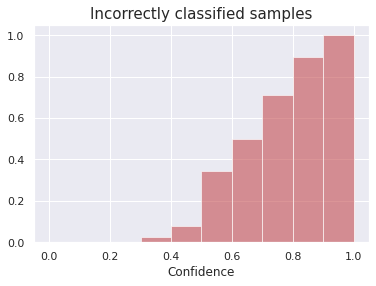

In [149]:
density=True
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.6)
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.6, cumulative=1)
# plt.title('Cumulative confidence distribution in misclassified samples\n', size=14)
plt.title('Incorrectly classified samples', size=15)
plt.xlabel('Confidence')
plt.show()

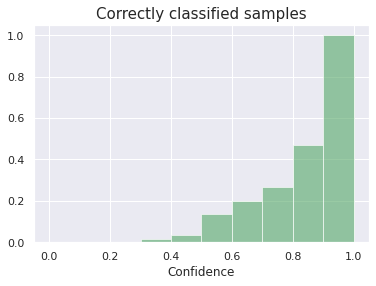

In [150]:
density=True
# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='b', alpha=0.6)
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='g', alpha=0.6, cumulative=1)
# plt.title('Cumulative confidence distribution in correctly classified samples\n', size=14)
plt.title('Correctly classified samples', size=15)
plt.xlabel('Confidence')
plt.show()

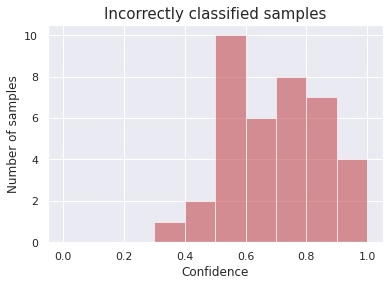

In [151]:
density=False
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, alpha=0.6, color='r')
# plt.title('Confidence distribution in misclassified samples\n', size=14)
plt.title('Incorrectly classified samples', size=15)
plt.xlabel('Confidence')
plt.ylabel('Number of samples')
plt.show()

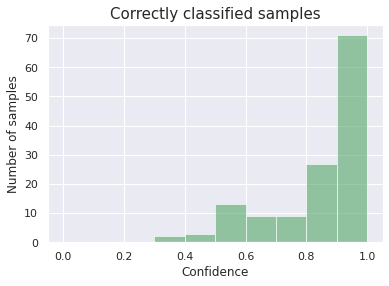

In [152]:
density=False
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, alpha=0.6, color='g')
# plt.title('Confidence distribution in correctly classified samples\n', size=14)
plt.title('Correctly classified samples', size=15)
plt.xlabel('Confidence')
plt.ylabel('Number of samples')
plt.show()

In [153]:
# misclassified_df = create_misclassified_df(X_test=X_valid_test, y_test=y_valid_test_, y_pred=y_pred)
# assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
# # misclassified_df

# df_merged = pd.merge(misclassified_df, df_text[['url', 'text']], on='text')
# df_merged.index = misclassified_df.index
# # df_merged

# df_confidences = df_merged[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
# # df_confidences.head()

# mask = y_pred != y_valid_test_

# confidence_pred = y_probs[mask, df_confidences['y_pred']]
# # confidence_pred

# confidence_true = y_probs[mask, df_confidences['y_true']]
# # confidence_true

# df_merged['conf_true'] = confidence_true.round(2)
# df_merged['conf_pred'] = confidence_pred.round(2)
# # df_merged.head()

# df_merged = df_merged[['url', 'text', 'y_true', 'conf_true', 'y_pred', 'conf_pred']]
# # df_merged.head()

# save_variable(df_merged, 'df_merged_nn')

# misclassified_urls = df_merged['url'].tolist()
# # misclassified_urls

# wrong_conf_pred = np.max(y_probs[mask], axis=1)
# # wrong_conf_pred[:3]

# right_conf_pred = np.max(y_probs[~mask], axis=1)
# # right_conf_pred[:3]

# assert y_probs.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

# print(f'Average confidence of misclassified samples: {np.mean(wrong_conf_pred):.4f}')
# print(f'Average confidence of correctly classified samples: {np.mean(right_conf_pred):.4f}')

# print(f'Median confidence of misclassified samples: {np.median(wrong_conf_pred):.4f}')
# print(f'Median confidence of correctly classified samples: {np.median(right_conf_pred):.4f}')

# density=None
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in misclassified samples')
# plt.show()

# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in correctly classified samples')
# plt.show()

### b) Modeling - DL approach:

In [182]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [183]:
tokenizer

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [184]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [185]:
# The column names to convert to TensorFlow tensors
# from transformers import DataCollatorForTokenClassification
# from transformers import DefaultDataCollator
from transformers import DataCollatorWithPadding

tokenizer_columns = tokenizer.model_input_names

# Define a batch size
batch_size = 16

# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")
# data_collator = DefaultDataCollator(return_tensors="tf")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = dataset_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, 
    label_cols=["label"], 
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
    )

tf_eval_dataset = dataset_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, 
    label_cols=["label"], 
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
    )

tf_train_dataset

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [186]:
tf_test_dataset = dataset_encoded["test"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["label"], 
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
    )

In [187]:
num_labels = len(y_train.value_counts())

In [188]:
from transformers import TFDistilBertModel, DistilBertConfig

DISTILBERT_DROPOUT = 0.2
DISTILBERT_ATT_DROPOUT = 0.1
 
# Configure DistilBERT's initialization
config = DistilBertConfig(
    dropout=DISTILBERT_DROPOUT, 
    attention_dropout=DISTILBERT_ATT_DROPOUT,
    output_hidden_states=True,
    num_labels=num_labels,
    )
                          
# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
# and without any specific head on top.
# tf_model = TFDistilBertModel.from_pretrained(
#     'distilbert-base-uncased', 
#     config=config
#     )

# # # Make tf_model layers untrainable
# for layer in tf_model.layers:
#     layer.trainable = False

In [189]:
from transformers import TFAutoModelForSequenceClassification
tf_model = (TFAutoModelForSequenceClassification.from_pretrained(
    model_ckpt, 
    config=config, 
    # num_labels=num_labels,
    )
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_38', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [190]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# With:
# DISTILBERT_DROPOUT = 0.1
# DISTILBERT_ATT_DROPOUT = 0.1

epochs = 1000
patience = 5

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy()
    )

callback = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
    )

history = tf_model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset, 
    epochs=epochs,
    callbacks=[callback]
    )

Epoch 1/1000
38/38 [==============================] - 48s 1s/step - loss: 1.7609 - sparse_categorical_accuracy: 0.2521 - val_loss: 1.6946 - val_sparse_categorical_accuracy: 0.4767
Epoch 2/1000
38/38 [==============================] - 37s 979ms/step - loss: 1.6179 - sparse_categorical_accuracy: 0.5893 - val_loss: 1.5302 - val_sparse_categorical_accuracy: 0.7093
Epoch 3/1000
38/38 [==============================] - 37s 980ms/step - loss: 1.4147 - sparse_categorical_accuracy: 0.6878 - val_loss: 1.3233 - val_sparse_categorical_accuracy: 0.6977
Epoch 4/1000
38/38 [==============================] - 37s 987ms/step - loss: 1.2047 - sparse_categorical_accuracy: 0.7078 - val_loss: 1.1303 - val_sparse_categorical_accuracy: 0.7093
Epoch 5/1000
38/38 [==============================] - 37s 982ms/step - loss: 1.0323 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.9867 - val_sparse_categorical_accuracy: 0.7209
Epoch 6/1000
38/38 [==============================] - 38s 988ms/step - loss: 0.8964 - sp

In [175]:
# tf.keras.models.save_model(
#     tf_model, 
#     filepath='/content/drive/MyDrive/url_classification/my_model_val0.84_test0.89', 
#     overwrite=True, 
#     save_format='tf'
#     )

In [ ]:
tf_model.save('/content/drive/MyDrive/Brew/my_model_val0.87_test0.8')

In [ ]:
# ! pwd

/content/drive/.shortcut-targets-by-id/1vLy-uUgLo6ivB3DawGntodciS6HG1L58/url_classification


In [176]:
# tf.saved_model.save(tf_model, '/content/drive/MyDrive/Brew/my_model_delete')

In [ ]:
from tensorflow.keras.models import load_model
tf_model2 = load_model(filepath='/content/drive/MyDrive/Brew/my_model_delete') 

In [ ]:
tf_model2 = tf.saved_model.load('/content/drive/MyDrive/Brew/my_model_delete')

In [188]:
tf.keras.models.save_model(tf_model, '/content/drive/MyDrive/url_classification/my_model_val0.81_test0.85')

In [ ]:
tf_model

In [186]:
tf_model2 = tf.keras.models.load_model(filepath='/content/drive/MyDrive/url_classification/my_model_val0.84_test0.89') 
# # why doesn't it work when running the next cell with the loaded model?

OSError: ignored

In [ ]:
custom_objects = {"TFAutoModelForSequenceClassification": TFAutoModelForSequenceClassification}

tf_model2 = tf.keras.models.load_model('/content/drive/MyDrive/Brew/my_model_delete', custom_objects=custom_objects)

In [178]:
# loss, train_accuracy = tf_model2.evaluate(tf_train_dataset)
# print("Loss: {}\t Train Accuracy: {}".format(loss, train_accuracy))

In [191]:
loss, train_accuracy = tf_model.evaluate(tf_train_dataset)
print("Loss: {}\t Train Accuracy: {}".format(loss, train_accuracy))

38/38 [==============================] - 12s 316ms/step - loss: 0.1531 - sparse_categorical_accuracy: 0.9750
Loss: 0.15307635068893433	 Train Accuracy: 0.9749582409858704


In [192]:
loss, eval_accuracy = tf_model.evaluate(tf_eval_dataset)
print("Loss: {}\t Eval Accuracy: {}".format(loss, eval_accuracy))

6/6 [==============================] - 2s 285ms/step - loss: 0.6126 - sparse_categorical_accuracy: 0.8256
Loss: 0.6125950813293457	 Eval Accuracy: 0.8255813717842102


In [193]:
loss, test_accuracy = tf_model.evaluate(tf_test_dataset)
print("Loss: {}\t Test Accuracy: {}".format(loss, test_accuracy))

11/11 [==============================] - 4s 325ms/step - loss: 0.5771 - sparse_categorical_accuracy: 0.8372
Loss: 0.5770680904388428	 Test Accuracy: 0.8372092843055725


In [194]:
output_logits = tf_model.predict(tf_test_dataset).logits
y_pred = np.argmax(output_logits, axis=-1)

11/11 [==============================] - 5s 321ms/step


In [195]:
y_pred

array([1, 0, 1, 1, 3, 5, 4, 4, 2, 4, 1, 3, 1, 0, 3, 3, 4, 3, 2, 2, 3, 4,
       4, 5, 2, 2, 5, 3, 3, 4, 1, 2, 5, 2, 1, 1, 1, 1, 0, 1, 4, 3, 3, 2,
       1, 1, 3, 4, 3, 2, 3, 1, 4, 3, 1, 4, 3, 4, 2, 3, 5, 0, 2, 4, 3, 1,
       2, 1, 4, 2, 1, 1, 2, 2, 1, 2, 4, 1, 1, 3, 2, 2, 4, 1, 1, 4, 0, 1,
       1, 4, 5, 2, 1, 1, 4, 1, 4, 4, 3, 3, 2, 5, 0, 3, 5, 4, 1, 2, 4, 5,
       1, 4, 0, 0, 3, 2, 2, 3, 3, 0, 2, 2, 4, 2, 3, 4, 1, 2, 1, 2, 3, 3,
       4, 5, 2, 1, 2, 4, 4, 5, 3, 4, 3, 1, 3, 1, 1, 2, 2, 4, 2, 3, 3, 0,
       0, 4, 3, 3, 2, 5, 2, 5, 4, 3, 2, 1, 2, 2, 2, 3, 1, 3])

In [196]:
y_probs = tf.nn.softmax(output_logits)
y_probs[:3]

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0.08416542, 0.878566  , 0.00733409, 0.01031895, 0.00701632,
        0.01259932],
       [0.7317688 , 0.05313385, 0.0171092 , 0.01492369, 0.12416278,
        0.05890167],
       [0.08567395, 0.85064834, 0.01047275, 0.03116656, 0.0085467 ,
        0.01349174]], dtype=float32)>

In [199]:
sns.set_theme(style='white')

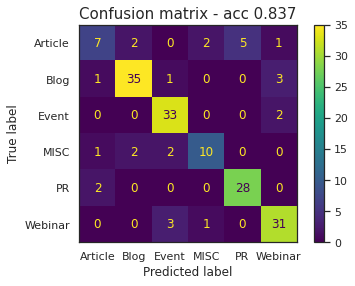


              precision    recall  f1-score   support

     Article       0.64      0.41      0.50        17
        Blog       0.90      0.88      0.89        40
       Event       0.85      0.94      0.89        35
        MISC       0.77      0.67      0.71        15
          PR       0.85      0.93      0.89        30
     Webinar       0.84      0.89      0.86        35

    accuracy                           0.84       172
   macro avg       0.81      0.79      0.79       172
weighted avg       0.83      0.84      0.83       172



In [200]:
print_confusion_matrix(y_test, y_pred, with_report=True)

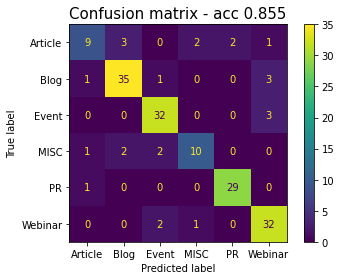


              precision    recall  f1-score   support

     Article       0.75      0.53      0.62        17
        Blog       0.88      0.88      0.88        40
       Event       0.86      0.91      0.89        35
        MISC       0.77      0.67      0.71        15
          PR       0.94      0.97      0.95        30
     Webinar       0.82      0.91      0.86        35

    accuracy                           0.85       172
   macro avg       0.84      0.81      0.82       172
weighted avg       0.85      0.85      0.85       172



In [185]:
print_confusion_matrix(y_test, y_pred, with_report=True)

In [201]:
y_pred

array([1, 0, 1, 1, 3, 5, 4, 4, 2, 4, 1, 3, 1, 0, 3, 3, 4, 3, 2, 2, 3, 4,
       4, 5, 2, 2, 5, 3, 3, 4, 1, 2, 5, 2, 1, 1, 1, 1, 0, 1, 4, 3, 3, 2,
       1, 1, 3, 4, 3, 2, 3, 1, 4, 3, 1, 4, 3, 4, 2, 3, 5, 0, 2, 4, 3, 1,
       2, 1, 4, 2, 1, 1, 2, 2, 1, 2, 4, 1, 1, 3, 2, 2, 4, 1, 1, 4, 0, 1,
       1, 4, 5, 2, 1, 1, 4, 1, 4, 4, 3, 3, 2, 5, 0, 3, 5, 4, 1, 2, 4, 5,
       1, 4, 0, 0, 3, 2, 2, 3, 3, 0, 2, 2, 4, 2, 3, 4, 1, 2, 1, 2, 3, 3,
       4, 5, 2, 1, 2, 4, 4, 5, 3, 4, 3, 1, 3, 1, 1, 2, 2, 4, 2, 3, 3, 0,
       0, 4, 3, 3, 2, 5, 2, 5, 4, 3, 2, 1, 2, 2, 2, 3, 1, 3])

In [202]:
y_test

831    1
932    4
821    1
843    1
642    3
      ..
404    2
405    2
563    3
909    1
580    3
Name: label, Length: 172, dtype: int64

In [203]:
mask = y_pred != y_test
mask

831    False
932     True
821    False
843    False
642    False
       ...  
404    False
405    False
563    False
909    False
580    False
Name: label, Length: 172, dtype: bool

In [204]:
y_pred

array([1, 0, 1, 1, 3, 5, 4, 4, 2, 4, 1, 3, 1, 0, 3, 3, 4, 3, 2, 2, 3, 4,
       4, 5, 2, 2, 5, 3, 3, 4, 1, 2, 5, 2, 1, 1, 1, 1, 0, 1, 4, 3, 3, 2,
       1, 1, 3, 4, 3, 2, 3, 1, 4, 3, 1, 4, 3, 4, 2, 3, 5, 0, 2, 4, 3, 1,
       2, 1, 4, 2, 1, 1, 2, 2, 1, 2, 4, 1, 1, 3, 2, 2, 4, 1, 1, 4, 0, 1,
       1, 4, 5, 2, 1, 1, 4, 1, 4, 4, 3, 3, 2, 5, 0, 3, 5, 4, 1, 2, 4, 5,
       1, 4, 0, 0, 3, 2, 2, 3, 3, 0, 2, 2, 4, 2, 3, 4, 1, 2, 1, 2, 3, 3,
       4, 5, 2, 1, 2, 4, 4, 5, 3, 4, 3, 1, 3, 1, 1, 2, 2, 4, 2, 3, 3, 0,
       0, 4, 3, 3, 2, 5, 2, 5, 4, 3, 2, 1, 2, 2, 2, 3, 1, 3])

In [205]:
np.array(y_test)

array([1, 4, 1, 1, 3, 0, 0, 4, 2, 4, 1, 1, 1, 0, 3, 1, 4, 3, 3, 2, 3, 4,
       4, 0, 2, 2, 5, 3, 3, 4, 1, 3, 5, 2, 1, 1, 1, 1, 4, 1, 4, 1, 3, 2,
       1, 0, 2, 0, 3, 2, 3, 1, 0, 3, 1, 4, 3, 4, 2, 3, 5, 0, 1, 4, 3, 1,
       2, 1, 4, 2, 1, 1, 2, 2, 1, 2, 4, 1, 1, 3, 2, 5, 0, 1, 1, 4, 0, 1,
       1, 4, 3, 5, 1, 0, 4, 1, 4, 4, 3, 3, 3, 5, 1, 3, 5, 4, 5, 2, 4, 5,
       1, 4, 0, 0, 3, 2, 2, 3, 3, 0, 2, 2, 0, 2, 3, 4, 1, 2, 1, 2, 3, 3,
       4, 5, 2, 5, 2, 4, 4, 5, 3, 4, 3, 1, 3, 1, 1, 2, 2, 4, 2, 3, 0, 0,
       5, 4, 3, 2, 2, 5, 2, 5, 4, 3, 2, 1, 2, 2, 2, 3, 1, 3])

In [206]:
len(y_test), len(y_pred)

(172, 172)

In [207]:
misclassified_df_nn = pd.DataFrame(
    {'y_true': y_test[mask].reset_index(drop=True).replace(labels_decoded),
     'y_pred': pd.Series(y_pred[mask]).replace(labels_decoded),
     }).set_index(y_test[mask].index)
misclassified_df_nn

,y_true,y_pred
932,PR,Article
713,Article,MISC
680,Article,PR
791,Blog,Webinar
904,Blog,Webinar
524,Webinar,Event
207,Article,MISC
538,Webinar,Event
951,PR,Article
842,Blog,Webinar


In [208]:
# I can merge with url/text using the index of y_test, do it later.

In [209]:
df_confidences_nn = misclassified_df_nn[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
df_confidences_nn.head()

,y_true,y_pred
932,4,0
713,0,5
680,0,4
791,1,3
904,1,3


In [210]:
y_probs_array = np.array(y_probs)

In [211]:
confidence_pred_nn = y_probs_array[mask, df_confidences_nn['y_pred']]
confidence_pred_nn

array([0.7317688 , 0.6880048 , 0.87609005, 0.8604847 , 0.9083877 ,
       0.6410547 , 0.81165284, 0.9317813 , 0.47587645, 0.9376277 ,
       0.61182654, 0.84027946, 0.8377481 , 0.8389856 , 0.851417  ,
       0.9430426 , 0.9203028 , 0.54665744, 0.9204443 , 0.8084895 ,
       0.9474942 , 0.32922313, 0.8855198 , 0.694019  , 0.7159665 ,
       0.85666305, 0.73370403, 0.9439738 ], dtype=float32)

In [212]:
confidence_true_nn = y_probs_array[mask, df_confidences_nn['y_true']]
confidence_true_nn

array([0.12416278, 0.06829616, 0.0711691 , 0.02685313, 0.02636965,
       0.26135868, 0.0567484 , 0.02559043, 0.4171192 , 0.01154234,
       0.32100692, 0.04748523, 0.11640108, 0.10977008, 0.0378789 ,
       0.01535015, 0.04170987, 0.31138265, 0.02573165, 0.14057119,
       0.0131673 , 0.25806272, 0.01883534, 0.22927858, 0.06642533,
       0.00938151, 0.05739936, 0.0123579 ], dtype=float32)

In [213]:
misclassified_df_nn['conf_true'] = confidence_true_nn.round(2)
misclassified_df_nn['conf_pred'] = confidence_pred_nn.round(2)
misclassified_df_nn.head()

,y_true,y_pred,conf_true,conf_pred
932,PR,Article,0.12,0.73
713,Article,MISC,0.07,0.69
680,Article,PR,0.07,0.88
791,Blog,Webinar,0.03,0.86
904,Blog,Webinar,0.03,0.91


In [214]:
misclassified_df_nn = misclassified_df_nn[['y_true', 'conf_true', 'y_pred', 'conf_pred']]
misclassified_df_nn

,y_true,conf_true,y_pred,conf_pred
932,PR,0.12,Article,0.73
713,Article,0.07,MISC,0.69
680,Article,0.07,PR,0.88
791,Blog,0.03,Webinar,0.86
904,Blog,0.03,Webinar,0.91
524,Webinar,0.26,Event,0.64
207,Article,0.06,MISC,0.81
538,Webinar,0.03,Event,0.93
951,PR,0.42,Article,0.48
842,Blog,0.01,Webinar,0.94


In [203]:
save_variable(misclassified_df_nn, 'df_merged_nn')

In [215]:
wrong_conf_pred = np.max(y_probs_array[mask], axis=1)
wrong_conf_pred[:3]

array([0.7317688 , 0.6880048 , 0.87609005], dtype=float32)

In [216]:
right_conf_pred = np.max(y_probs_array[~mask], axis=1)
right_conf_pred[:3]

array([0.878566  , 0.85064834, 0.9120738 ], dtype=float32)

In [217]:
assert y_probs_array.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

In [291]:
print(f'Confidence of incorrectly classified samples \t- Median: {np.median(wrong_conf_pred):.4f}, Mean: {np.mean(wrong_conf_pred):.4f}.')
print(f'Confidence of correctly classified samples \t- Median: {np.median(right_conf_pred):.4f}, Mean: {np.mean(right_conf_pred):.4f}.')

Confidence of incorrectly classified samples 	- Median: 0.8021, Mean: 0.7702.
Confidence of correctly classified samples 	- Median: 0.9231, Mean: 0.8750.


In [259]:
sns.set_theme()

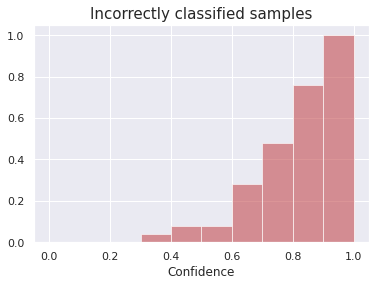

In [310]:
density=True
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.6)
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='r', alpha=0.6, cumulative=1)
# plt.title('Cumulative confidence distribution in misclassified samples\n', size=14)
plt.title('Incorrectly classified samples', size=15)
plt.xlabel('Confidence')
plt.show()

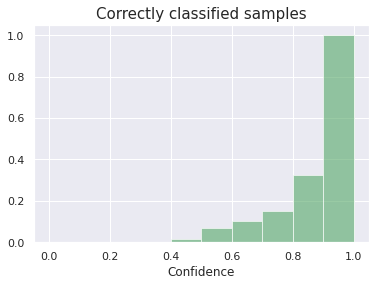

In [311]:
density=True
# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='b', alpha=0.6)
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, color='g', alpha=0.6, cumulative=1)
# plt.title('Cumulative confidence distribution in correctly classified samples\n', size=14)
plt.title('Correctly classified samples', size=15)
plt.xlabel('Confidence')
plt.show()

In [241]:
total_count = len(wrong_conf_pred)
weights = [1 / total_count for x in wrong_conf_pred]

In [244]:
weights = 0.04

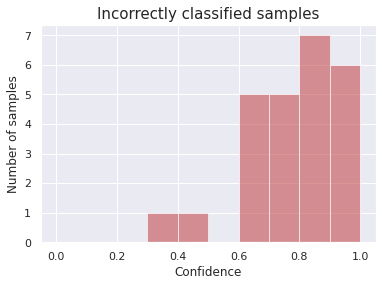

In [303]:
density=False
plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density, alpha=0.6, color='r')
# plt.title('Confidence distribution in misclassified samples\n', size=14)
plt.title('Incorrectly classified samples', size=15)
plt.xlabel('Confidence')
plt.ylabel('Number of samples')
plt.show()

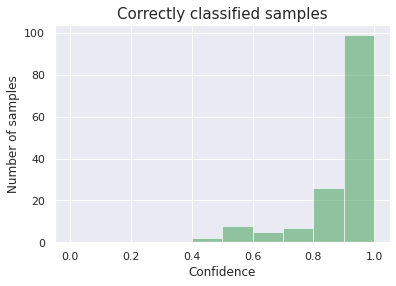

In [304]:
density=False
plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density, alpha=0.6, color='g')
# plt.title('Confidence distribution in correctly classified samples\n', size=14)
plt.title('Correctly classified samples', size=15)
plt.xlabel('Confidence')
plt.ylabel('Number of samples')
plt.show()

In [ ]:
# misclassified_df = create_misclassified_df(X_test=X_valid_test, y_test=y_test, y_pred=y_pred)
# assert (misclassified_df['y_true'] != misclassified_df['y_pred']).all()
# misclassified_df

# df_merged = pd.merge(misclassified_df, df_text[['url', 'text']], on='text')
# df_merged.index = misclassified_df.index
# # df_merged

# df_confidences = df_merged[['y_true', 'y_pred']].applymap(lambda x: labels_encoded[x])
# # df_confidences.head()

# mask = y_pred != y_valid_test_

# confidence_pred = y_probs[mask, df_confidences['y_pred']]
# # confidence_pred

# confidence_true = y_probs[mask, df_confidences['y_true']]
# # confidence_true

# df_merged['conf_true'] = confidence_true.round(2)
# df_merged['conf_pred'] = confidence_pred.round(2)
# # df_merged.head()

# df_merged = df_merged[['url', 'text', 'y_true', 'conf_true', 'y_pred', 'conf_pred']]
# # df_merged.head()

# save_variable(df_merged, 'df_merged_nn')

# misclassified_urls = df_merged['url'].tolist()
# # misclassified_urls

# wrong_conf_pred = np.max(y_probs[mask], axis=1)
# # wrong_conf_pred[:3]

# right_conf_pred = np.max(y_probs[~mask], axis=1)
# # right_conf_pred[:3]

# assert y_probs.shape[0] == wrong_conf_pred.shape[0] + right_conf_pred.shape[0]

# print(f'Average confidence of misclassified samples: {np.mean(wrong_conf_pred):.4f}')
# print(f'Average confidence of correctly classified samples: {np.mean(right_conf_pred):.4f}')

# print(f'Median confidence of misclassified samples: {np.median(wrong_conf_pred):.4f}')
# print(f'Median confidence of correctly classified samples: {np.median(right_conf_pred):.4f}')

# density=None
# plt.hist(wrong_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in misclassified samples')
# plt.show()

# plt.hist(right_conf_pred, bins=np.linspace(0, 1, 11), density=density)
# plt.title('Distribution of confidence in correctly classified samples')
# plt.show()